# Modeling Calcium Dynamics for Myoepithelial Cells in _Hydra_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.integrate import odeint

# Single cellular dynamics

Simulations of intracellular calcium dynamics. 

## I. Inexcitable cell

The model in this section has no voltage-dependent channels or processes thus it's inexcitable. 

### Parameters

In [2]:
# Numerical parameters
T = 200
dt = 0.005
TIME = np.linspace(0, T+dt, int(T/dt)+1)

# Initial conditions 
c0 = 0.0865415
h0 = 0.6255124
ct0 = 36.49084
ip0 = 0

# Volume ratio
gamma=5.4054

# Leak for ER
v_leak = 0.002

# Leak across plasma membrane
v_in = 0.05
k_out = 1.2

# IP3R parameters
v_ip3r = 0.4
d_1 = 0.13; d_2 = 1.049; d_3 = 0.9434; d_5= 0.08234; 
a_2 = 0.04

# PMCA terms
v_pmca = 10
k_pmca = 2.5

# SOC terms
v_soc = 1.57
k_soc = 90

# SERCA terms
v_serca = 0.9
k_serca = 0.1

# Sneyd Parameter
delta = 0.2

# IP3 parameters
d_rise = 6
r_rise = 0.025 #0.025 
r_decay = 0.025

### Functions

In the stable state, the amount of currents through ER and through membrane should separately be zero, which means 
$$j_{ip_3r} + j_{leak} - j_{serca} = 0$$
and 
$$j_{in} - j_{out} - j_{pmca} + j_{soc} = 0$$

In [3]:
# Terms on ER
def j_ip3r(c, c_t, h, ip):
    '''IP3R current, ER -> cytosol'''
    m_inf = ip/(ip+d_1)
    n_inf = c/(c+d_5)

    return v_ip3r * m_inf**2 * n_inf**2 * h**0.5 * \
    ((c_t-c)*gamma - c)**0.5

def j_leak(c, c_t):
    '''leak current, ER -> cytosol'''
    return v_leak * ((c_t-c)*gamma - c)

def j_serca(c):
    '''SERCA pump, cytosol -> ER'''
    return v_serca* c**1.75 / (c**1.75 + k_serca**1.75)

# Terms on membrane
def j_in():
    '''input current, outside -> cytosol'''
    return v_in

def j_out(c):
    '''output current, cytosol -> outside'''
    return k_out * c

def j_pmca(c):
    '''PMCA pump, cytosol -> outside'''
    return v_pmca * c**2 / (k_pmca**2 + c**2)

def j_soc(c, c_t):
    '''SOCC, outside -> cytosol'''
    return v_soc * k_soc**4 / (k_soc**4 + ((c_t-c)*gamma)**4)

# Terms for IP3R
def h_inf(c, ip):
    '''stable IP3 inactivation rate'''
    q_2 = d_2 * (ip + d_1)/(ip + d_3)
    return q_2 / (q_2 + c)

def tau_h(c, ip):
    '''time constant for IP3 inactivation rate'''
    q_2 = d_2 * (ip + d_1)/(ip + d_3)
    return 1 / (a_2 * (q_2 + c))

### Stimulation Settings

Multiple stimulations are allowed.

In [4]:
st1 = 20.0
st2 = 40.0
st3 = 60.0
st4 = 80.0

def stim(t):
    '''returns the stimulation status at time t'''
    if t >= st1 and t < st1+d_rise:
        return 1
    elif t >= st2 and t < st2+d_rise:
        return 1
    elif t >= st3 and t < st3+d_rise:
        return 1
    elif t >= st4 and t < st4+d_rise:
        return 1
    else:
        return 0
    
stim_train = np.array([stim(j*dt) for j in range(len(TIME))])

### Simulation

Four cellular variables will be integrated:

- **c(t)**: cytosolic Ca2+ concentration
- **c_t(t)**: stores Ca2+ concentration
- **ip(t)**: cytosolic IP3 concentration
- **h(t)**: IP3 inactivation variable

In [5]:
def rhs(y, t):
    '''right-hand side for integration in section I'''
    c, c_t, h, ip = y
    
    dcdt = j_ip3r(c, c_t, h, ip) - j_serca(c) + j_leak(c, c_t) + \
    (j_in() - j_out(c) - j_pmca(c) + j_soc(c,c_t))*delta
    
    dctdt =  (j_in() - j_out(c) - j_pmca(c) + j_soc(c,c_t))*delta
    
    dhdt =  (h_inf(c, ip)-h)/tau_h(c, ip)
    
    dipdt = r_rise * stim(t) - r_decay * ip
    
    return [dcdt, dctdt, dhdt, dipdt]

In [6]:
# initial conditions
t = np.linspace(0, T, int(T/dt))

y0 = [c0, ct0, h0, ip0]
sol = odeint(rhs, y0, t, hmax = 0.005)

c = sol[:, 0]
c_t = sol[:, 1]
h = sol[:, 2]
ip = sol[:, 3]

### Plot the results

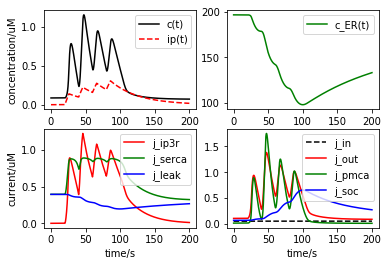

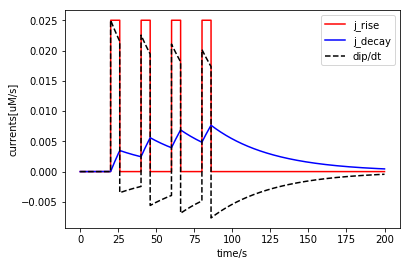

In [7]:
plt.figure()
plt.subplot(2,2,1)
plt.plot(TIME[0:-1], c, 'k-', label = 'c(t)')
plt.plot(TIME[0:-1], ip, 'r--', label = 'ip(t)')
plt.xlabel('time/s')
plt.ylabel('concentration/uM')
plt.legend()
#plt.show()

plt.subplot(2,2,2)
#plt.plot(TIME[0:-1], c_t, 'b-', label = 'c_t(t)')
plt.plot(TIME[0:-1], (c_t-c)*gamma, 'g-', label = 'c_ER(t)')
plt.xlabel('time/s')
#plt.ylabel('concentration/uM')
plt.legend()
#plt.show()

plt.subplot(2,2,3)
plt.plot(TIME[0:-1], j_ip3r(c, c_t, h, ip), 'r-', label = 'j_ip3r')
plt.plot(TIME[0:-1], j_serca(c), 'g-', label = 'j_serca')
plt.plot(TIME[0:-1], j_leak(c,c_t), 'b-', label = 'j_leak')
plt.xlabel('time/s')
plt.ylabel('current/uM')
plt.legend()
#plt.show()

plt.subplot(2,2,4)
plt.plot(TIME[0:-1], [j_in()]*40000, 'k--', label = 'j_in')
plt.plot(TIME[0:-1], j_out(c), 'r-', label = 'j_out')
plt.plot(TIME[0:-1], j_pmca(c), 'g-', label = 'j_pmca')
plt.plot(TIME[0:-1], j_soc(c,c_t), 'b-', label = 'j_soc')
plt.xlabel('time/s')
#plt.ylabel('current/uM')
plt.legend()
plt.show()

plt.plot(TIME[0:-1], r_rise*stim_train[0:-1], 'r-', label = 'j_rise')
plt.plot(TIME[0:-1], r_decay * ip, 'b-', label = 'j_decay')
plt.plot(TIME[0:-1], r_rise*stim_train[0:-1]-r_decay * ip, 'k--', label = 'dip/dt')
plt.xlabel('time/s')
plt.ylabel('currents[uM/s]')
plt.legend(loc='upper right')
plt.show()

## II. Excitable cell

In this section, membrane potential is introduced into the model and is assumed to facilitate the synthesis of IP3. 

- ### Hypothesis 1: 

Stimulus directly increases the concentration of IP3, which give rise to the increase of [Ca2+]; 

voltage increase comes from CaV channels, and then voltage facilitates the synthesis of IP3.

Calcium-induced voltage channel is also introduced and embedded on the cytoplasmic membrane. 

A positive feedback loop is thus formed (IP3 $\rightarrow$ Ca$^{2+}\rightarrow$ V $\rightarrow$ IP3)

#### Modified or new parameters

In [8]:
# CaV terms
v_cav = 4.0
k_cav = 1.4
e_cav = -20
q = 1 # Hill coefficient

# Ionic terms
v_ion = 1.12
e_ion = -67.2

# Membrane capacitance
c_m = 0.0017e3

# Initial conditions
v0 = -59.076

# Modified parameters
r_decay2 = 0.06

# V-induced IP3 term
v_vip = 0.05
k_vip = -58

# Nonlinear IP3 term
v_deg = 0
k_deg = 0.5

#### Functions

Still, the equilibrium conditions need to be satisfied separately for ER terms and membrane terms. 

Except for the above two equations (1) and (2), one more equation should hold at equilibrium:

$$j_{cav} - j_{ionic} = 0$$

In [9]:
def j_cav(c, v):
    '''calcium-induced voltage channel'''
    return -v_cav * c**q / (c**q + k_cav**q) * (v - e_cav)

def j_ionic(v):
    '''passive ionic leak channel'''
    return v_ion * (v - e_ion)

def j_vip(v, h_vip):
    '''voltage-induced ip3 synthesis'''
    return v_vip * (v-v0)**h_vip

def j_deg(ip, h_deg):
    '''nonlinear degration of ip3'''
    return v_deg * ip**h_deg / (ip**h_deg + k_deg**h_deg)

In [10]:
def rhs21(y, t):
    '''right-hand side for integration in hypothesis 1'''
    c, c_t, h, ip, v = y
    
    dcdt = j_ip3r(c, c_t, h, ip) - j_serca(c) + j_leak(c, c_t) + \
    (j_in() - j_out(c) - j_pmca(c) + j_soc(c,c_t))*delta
    
    dctdt =  (j_in() - j_out(c) - j_pmca(c) + j_soc(c,c_t))*delta
    
    dhdt = (h_inf(c, ip)-h)/tau_h(c, ip)
    
    dipdt = r_rise * stim(t) - r_decay2 * ip  + j_vip(v,1)
    
    dvdt = (j_cav(c,v) - j_ionic(v)) / c_m 
    
    return [dcdt, dctdt, dhdt, dipdt, dvdt]

- **Hypothesis 2**:

Stimulus increases the membrane potential (voltage), which facilitates the synthesis of IP3.

There is no CaV in this hypothesis and voltage increase only comes from stimulation and electrical coupling, thus there is **no positive feedback** in this hypothesis. 

In [11]:
# Initial condition
v0 = -59.076

# j_stim terms
v_st = 50

# Voltage leak terms
v_l = 2
e_l = v0

# Voltage-dependent IP3 terms
r_vip2 = 0.0008

In [12]:
def j_stim(st):
    '''stimulation-induced voltage increase'''
    return v_st * st

def j_l(v):
    '''voltage leak'''
    return v_l*(v-e_l)

In [13]:
def rhs22(y, t):
    '''right-hand side for integration in hypothesis 2'''
    c, c_t, h, ip, v = y
    
    dcdt = j_ip3r(c, c_t, h, ip) - j_serca(c) + j_leak(c, c_t) + \
    (j_in() - j_out(c) - j_pmca(c) + j_soc(c,c_t))*delta
    
    dctdt =  (j_in() - j_out(c) - j_pmca(c) + j_soc(c,c_t))*delta
    
    dhdt = (h_inf(c, ip)-h)/tau_h(c, ip)
    
    dipdt = r_vip2 * (v-v0) - r_decay * ip
    
    dvdt = j_stim(stim(t)) - j_l(v)
    
    return [dcdt, dctdt, dhdt, dipdt, dvdt]

### Simulation

Five cellular variables will be integrated:

- **c(t)**: cytosolic Ca2+ concentration
- **c_t(t)**: stores Ca2+ concentration
- **ip(t)**: cytosolic IP3 concentration
- **h(t)**: IP3 inactivation variable
- **v(t)**: membrane potential

In [14]:
# initial conditions
t = np.linspace(0, T, int(T/dt))
y0 = [c0, ct0, h0, ip0, v0]

# integrate
sol = odeint(rhs22, y0, t, hmax = 0.005)

c = sol[:, 0]
c_t = sol[:, 1]
h = sol[:, 2]
ip = sol[:, 3]
v = sol[:, 4]

### Plot the results

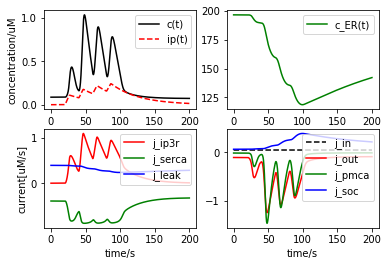

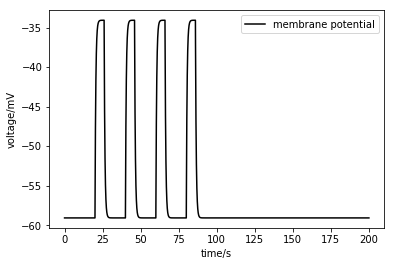

In [15]:
plt.figure()
plt.subplot(2,2,1)
plt.plot(TIME[0:-1], c, 'k-', label = 'c(t)')
plt.plot(TIME[0:-1], ip, 'r--', label = 'ip(t)')
plt.xlabel('time/s')
plt.ylabel('concentration/uM')
plt.legend()
#plt.show()

plt.subplot(2,2,2)
#plt.plot(TIME[0:-1], c_t, 'b-', label = 'c_t(t)')
plt.plot(TIME[0:-1], (c_t-c)*gamma, 'g-', label = 'c_ER(t)')
plt.xlabel('time/s')
#plt.ylabel('concentration/uM')
plt.legend()
#plt.show()

plt.subplot(2,2,3)
plt.plot(TIME[0:-1], j_ip3r(c, c_t, h, ip), 'r-', label = 'j_ip3r')
plt.plot(TIME[0:-1], -j_serca(c), 'g-', label = 'j_serca')
plt.plot(TIME[0:-1], j_leak(c,c_t), 'b-', label = 'j_leak')
plt.xlabel('time/s')
plt.ylabel('current[uM/s]')
plt.legend(loc='upper right')
#plt.show()

plt.subplot(2,2,4)
plt.plot(TIME[0:-1], [j_in()]*40000, 'k--', label = 'j_in')
plt.plot(TIME[0:-1], -j_out(c), 'r-', label = 'j_out')
plt.plot(TIME[0:-1], -j_pmca(c), 'g-', label = 'j_pmca')
plt.plot(TIME[0:-1], j_soc(c,c_t), 'b-', label = 'j_soc')
plt.xlabel('time/s')
# plt.ylabel('current/uM')
plt.legend(loc='upper right')

plt.show()

plt.figure()
plt.plot(TIME[0:-1], v, 'k-', label = 'membrane potential')
plt.xlabel('time/s')
plt.ylabel('voltage/mV')
plt.legend()
plt.show()

#plt.subplot(3,1,2)
#plt.plot(TIME[0:-1], j_cav(c,v), 'r-', label = 'j_cav')
#plt.plot(TIME[0:-1], j_ionic(v), 'b-', label = 'j_ionic')
#plt.xlabel('time/s')
#plt.ylabel('currents/uA')
#plt.legend(loc='upper right')

#plt.subplot(3,1,3)
#plt.plot(TIME[0:-1], r_rise*stim_train[0:-1], 'r-', label = 'j_rise')
#plt.plot(TIME[0:-1], r_decay2 * ip, 'b-', label = 'j_decay')
#plt.plot(TIME[0:-1], j_vip(v,1), 'k-', label = 'j_vip')
#plt.xlabel('time/s')
#plt.ylabel('currents[uM/s]')
#plt.legend(loc='upper right')
#plt.show()

# Multicellular dynamics

Simulations of intercellular calcium dynamics

Cells coupled through gap-junctions

In [16]:
from scipy.sparse import spdiags

## III. Inexcitable cells (chemical diffusion coupling)

- ## 1D case

## IV. Excitable cells (electrical coupling) 

- ## 1D case

Cells are aligned in sequence as a chain.

### Layout

In [46]:
# Number of cells
N = 10

# Electrical coupling coefficient
gc = 200

# Grid initialization
vec_c = np.zeros(N)
vec_ct = np.zeros(N)
vec_h = np.zeros(N)
vec_ip = np.zeros(N)
vec_v = np.zeros(N)

### Define coupling matrix

In [47]:
onex = np.ones(N)
Dx = spdiags(np.array([onex,-2*onex,onex]),\
        np.array([-1,0,1]),N,N).toarray()
Dx[0,0] = -1; Dx[N-1,N-1] = -1

### Modify parameters

In [48]:
v_st = 200

### Simulation

In [49]:
def rhs3(y,t):
    '''right-hand side for integration in section III'''
    c, c_t, h, ip, v = \
    y[0:N], y[N:2*N], y[2*N:3*N], y[3*N:4*N], y[4*N:5*N]
    
    dipdt = np.zeros(N)
    
    dcdt = j_ip3r(c, c_t, h, ip) - j_serca(c) + j_leak(c, c_t) + \
    (j_in() - j_out(c) - j_pmca(c) + j_soc(c,c_t))*delta
    
    dctdt =  (j_in() - j_out(c) - j_pmca(c) + j_soc(c,c_t))*delta
    
    dhdt =  (h_inf(c, ip)-h)/tau_h(c, ip)

    dipdt = r_vip2 * (v-v0) - r_decay * ip
    
    dvdt = - j_l(v) + gc * Dx@v
    dvdt[0:3] += j_stim(stim(t))
    
    deriv = np.array([dcdt, dctdt, dhdt, dipdt, dvdt])
    
    dydt = np.reshape(deriv, 5*N)
    
    return dydt
        

In [50]:
st1 = 20.0
st2 = 40.0
st3 = 60.0
st4 = 80.0

In [51]:
# initial conditions
t = np.linspace(0, T, int(T/dt))
y0 = np.array([[c0]*N, [ct0]*N, [h0]*N, [ip0]*N, [v0]*N])
y0 = np.reshape(y0, 5*N)

# integrate
sol = odeint(rhs3, y0, t, hmax = 0.005) 

In [52]:
c = sol[:, 0:N]
c_t = sol[:, N:2*N]
h = sol[:, 2*N:3*N]
ip = sol[:, 3*N:4*N]
v = sol[:, 4*N:5*N]

### Plot the results

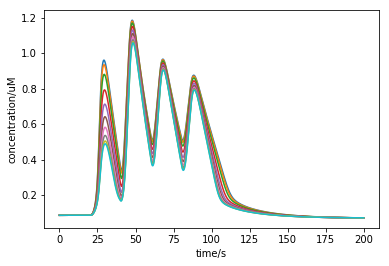

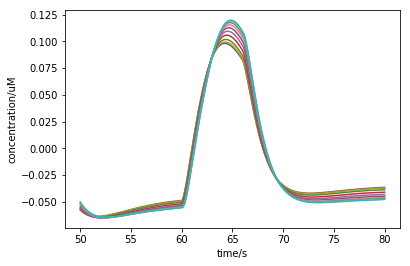

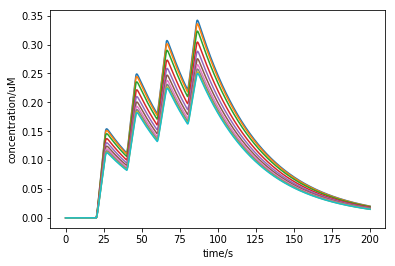

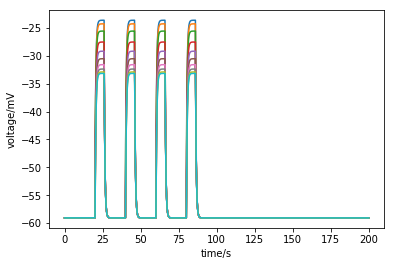

In [53]:
plt.figure()
plt.plot(TIME[0:-1], c, '-', label = 'c(t)')
#plt.plot(TIME[5000:8000], c[5000:8000], '-', label = 'c(t)')
#plt.plot(TIME[0:-1], ip, '--', label = 'ip(t)')
plt.xlabel('time/s')
plt.ylabel('concentration/uM')
#plt.legend()
plt.show()

plt.figure()
#plt.plot(TIME[0:-1], (j_ip3r(c, c_t, h, ip) - j_serca(c) + j_leak(c, c_t) + \
#    (j_in() - j_out(c) - j_pmca(c) + j_soc(c,c_t))*delta), '-', label = 'dc(t)/dt')
plt.plot(TIME[10000:16000], (j_ip3r(c, c_t, h, ip) - j_serca(c) + j_leak(c, c_t) + \
    (j_in() - j_out(c) - j_pmca(c) + j_soc(c,c_t))*delta)[10000:16000], '-', label = 'c(t)')
#plt.plot(TIME[0:-1], ip, '--', label = 'ip(t)')
plt.xlabel('time/s')
plt.ylabel('concentration/uM')
#plt.legend()
plt.show()

plt.figure()
plt.plot(TIME[0:-1], ip, '-', label = 'ip(t)')
#plt.plot(TIME[12000:15000], ip[12000:15000], '-', label = 'ip(t)')
plt.xlabel('time/s')
plt.ylabel('concentration/uM')
#plt.legend()
plt.show()

plt.figure()
plt.plot(TIME[0:-1], v, label = 'membrane potential')
plt.xlabel('time/s')
plt.ylabel('voltage/mV')
#plt.legend()
plt.show()
